# **Token-level Grammatical Error Detection using BERT**




---

## **1. Data Understanding**

### **1.1 Loading Training Data**

In [1]:
#loading data
import pandas as pd

df = pd.read_csv("en_fce_train.tsv", delimiter='\t', skip_blank_lines=False ,header=None, names=['token', 'label'])
df.head(20)

,token,label
0,Dear,c
1,Sir,c
2,or,c
3,Madam,c
4,",",c
5,NaN,NaN
6,I,c
7,am,c
8,writing,c
9,in,c


### **1.2 Exploratory Data Analysis**

#### **1.2.1 About The Dataset**

The Cambridge Learner Corpus First Certificate in English (CLC FCE) is an exam for english learners the publicly  released dataset consists of  33,673 sentences split into test and training sets of 2,720 and 30,953 sentences, respectively. Data provided by MultiGED-2023 is the tokenised version of the English FCE data, in which each token word is labelled as either 'c' or 'i', for 'grammatically correct' and 'grammatically incorrect' respectively.

#### **1.2.2 Size of Dataset**

In [2]:
df.shape

(483087, 2)

#### **1.2.3 Checking for Imbalance in Dataset**

label
c    90.56605
i     9.43395
Name: count, dtype: float64


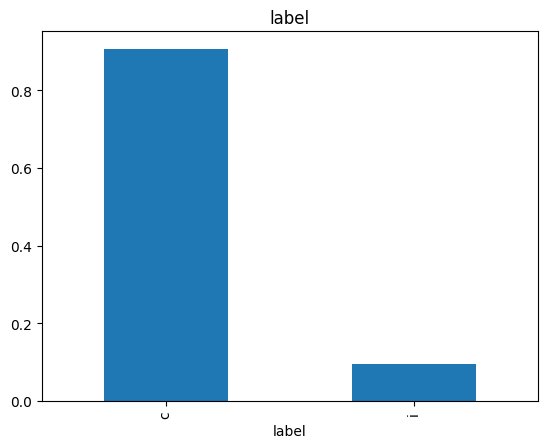

In [4]:
#checking if data is imbalance or not
def imbalance(target_column):
    return (target_column.value_counts()/target_column.value_counts().sum())*100

print(imbalance(df['label']))

#plotting bar plot of labels
import matplotlib.pyplot as plt
df['label'].value_counts(normalize=True).plot(kind='bar')
plt.title('label')
plt.show()

Here, around 90% of labelled as 'c' and rest as 'i'.

---

## **2. Data Preparation**

### **2.1 Data Manipulation**

Given training data is in the form of:  
token1 -> label1  
token2 -> label2  
token3 -> label3  
...  
  
We want in the form of:  
sentences = [[token1, token2], [token3, token4, token5]...]  
labels = [[label1, label2], [label3, label4, label5]...]



So that we can pass this to BERT as asequence along with the corresponding labels.

In [5]:
sentences = []
labels = []
unique_labels = set()

temp_sentences = []
temp_labels = []

for index, row in df.iterrows():
    if pd.notna(row["token"]):
        temp_sentences.append(row['token'])
        temp_labels.append(row['label'])
    else:
        sentences.append(temp_sentences)
        labels.append(temp_labels)
        unique_labels.update(temp_labels)
        temp_sentences = []
        temp_labels = []

if temp_sentences:
    sentences.append(temp_sentences)
    labels.append(temp_labels)
    unique_labels.update(temp_labels)

In [7]:
print(unique_labels)
print(sentences[1])
print(labels[1])

{'i', 'c'}
['I', 'am', 'writing', 'in', 'order', 'to', 'express', 'my', 'disappointment', 'about', 'your', 'musical', 'show', '\\"', 'Over', 'the', 'Rainbow', '\\"', '.']
['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'i', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


In [8]:
# Map each unique label to an integer.
label_map = {'i': 0, 'c': 1}
label_map

{'i': 0, 'c': 1}

In [9]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 28,360


### **2.2 Tokenizing Data**

#### **2.2.1 Downloading Transformers from HuggingFace**

In [10]:
!pip install transformers

#### **2.2.2 Importing Bert Tokenizer**

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### **2.2.3 Computing Max Length**

In [12]:
#to record the length of each sequence and reconstructing the sentence to let BERT decide how to tokenize it

lengths = []
for i in sentences:
    i = ' '.join(i)
    encoded_sent = tokenizer.encode(i, add_special_tokens = True)
    lengths.append(len(encoded_sent))

print('Max length: {:,} tokens'.format(max(lengths)))

Max length: 138 tokens


#### **2.2.4 Input IDs and Attention Mask**

In [13]:
#tokenizing sentences and mapping tokens to corresponding word IDs from BERT vocabulary
input_ids = []
attention_masks = []
for sent in sentences:
    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#### **2.2.5 Labels**

We want labels to be a number so that we can train model. So we will use the label_map dictionary to replace 'c' with 1 and 'i' with 0 and create a new list of labels. While doing this we also want to make sure that the new labels list is properly padded but we want to distinguish padded values from actual values of labels. So we will append null label id (-100). This way model will be trained on 3 labels 0, 1 and -100. But since the attention mask for the label values -100 is 0, it will not create any problem in training.

In [14]:
new_labels = []
null_label_id = -100
for sen, orig_labels in zip(input_ids, labels):
  padded_labels = []
  orig_labels_i = 0
  n = len(orig_labels)
  for token_id in sen:
    token_id = token_id.numpy().item()
    if (token_id == tokenizer.pad_token_id) or (token_id == tokenizer.cls_token_id) or (token_id == tokenizer.sep_token_id):
      padded_labels.append(null_label_id)
    elif tokenizer.ids_to_tokens[token_id][0:2] == "##":
      padded_labels.append(null_label_id)
    else:
      if orig_labels_i < n:
        padded_labels.append(label_map[orig_labels[orig_labels_i]])
        orig_labels_i += 1
  new_labels.append(padded_labels)


In [15]:
print('\nSentence:    ', sentences[1])
print('\Old Labels:      ', labels[1])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[1])))
print('\nToken IDs:   ', input_ids[1])
print('\nNew Labels:  ', new_labels[1])
print('\nAttention Mask: ', attention_masks[1])


Sentence:     ['I', 'am', 'writing', 'in', 'order', 'to', 'express', 'my', 'disappointment', 'about', 'your', 'musical', 'show', '\\"', 'Over', 'the', 'Rainbow', '\\"', '.']
\Old Labels:       ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'i', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']

BERT Tokens:  ['i', 'am', 'writing', 'in', 'order', 'to', 'express', 'my', 'disappointment', 'about', 'your', 'musical', 'show', '\\', '"', 'over', 'the', 'rainbow', '\\', '"', '.']

Token IDs:    tensor([  101,  1045,  2572,  3015,  1999,  2344,  2000,  4671,  2026, 10520,
         2055,  2115,  3315,  2265,  1032,  1000,  2058,  1996, 10098,  1032,
         1000,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

### **2.3 Padding**

In [16]:
from keras.utils import pad_sequences

input_ids = pad_sequences(input_ids, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")
new_labels = pad_sequences(new_labels, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")

### **2.4 List to Pytorch Tensors**

In [22]:
import torch

input_ids_tensors = [torch.tensor(arr) for arr in input_ids]
attention_masks_tensors = [torch.tensor(arr) for arr in attention_masks]

pt_input_ids = torch.stack(input_ids_tensors, dim=0)
pt_attention_masks = torch.stack(attention_masks_tensors, dim=0)
pt_labels = torch.tensor(new_labels)

<ipython-input-22-8ed8e4c9a044>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks_tensors = [torch.tensor(arr) for arr in attention_masks]


### **2.5 Creating Batches**

In [23]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

25,524 training samples
2,836 validation samples


In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

---

## **3. Modelling**

#### **3.1 Detecting GPU**

In [27]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    gpu_details = tf.config.experimental.get_device_details(physical_devices[0])
    print(f"Found GPU at: {device_name}")
    print("GPU Name:", gpu_details.get("device_name", "Unknown GPU"))
    print("CUDA Version:", tf.sysconfig.get_build_info()["cuda_version"])
    print("CUDNN Version:", tf.sysconfig.get_build_info()["cudnn_version"])
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0
GPU Name: Tesla T4
CUDA Version: 12.3
CUDNN Version: 8


#### **3.2 Using GPU if found**

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### **3.3 BERT Architecture**

In [29]:
from transformers import BertForTokenClassification, AdamW, BertConfig

model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", #12-layer uncased vocab BERT model
    num_labels = len(label_map) + 1,
    output_attentions = False,
    output_hidden_states = False,
    )

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [30]:
#printing model's parameters
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('Embedding Layer \n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\nTransformer Layer \n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\nOutput Layer \n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

Embedding Layer 

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

Transformer Layer 

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder

### **3.4 Optimizer and Scheduler**

In [31]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### **3.5 Training Loop**

In [33]:
import time
import numpy as np
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    print('\nEpoch {:} / {:}'.format(epoch_i + 1, epochs))

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = result.loss

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print()
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))


print()
print("Training complete!")


Epoch 1 / 4
Batch    40  of    798.    Elapsed: 0:00:49.
Batch    80  of    798.    Elapsed: 0:01:38.
Batch   120  of    798.    Elapsed: 0:02:29.
Batch   160  of    798.    Elapsed: 0:03:20.
Batch   200  of    798.    Elapsed: 0:04:12.
Batch   240  of    798.    Elapsed: 0:05:04.
Batch   280  of    798.    Elapsed: 0:05:56.
Batch   320  of    798.    Elapsed: 0:06:48.
Batch   360  of    798.    Elapsed: 0:07:40.
Batch   400  of    798.    Elapsed: 0:08:31.
Batch   440  of    798.    Elapsed: 0:09:23.
Batch   480  of    798.    Elapsed: 0:10:15.
Batch   520  of    798.    Elapsed: 0:11:07.
Batch   560  of    798.    Elapsed: 0:11:59.
Batch   600  of    798.    Elapsed: 0:12:51.
Batch   640  of    798.    Elapsed: 0:13:43.
Batch   680  of    798.    Elapsed: 0:14:34.
Batch   720  of    798.    Elapsed: 0:15:26.
Batch   760  of    798.    Elapsed: 0:16:18.

Average training loss: 0.24
Training epoch took: 0:17:07

Epoch 2 / 4
Batch    40  of    798.    Elapsed: 0:00:52.
Batch    80  of 

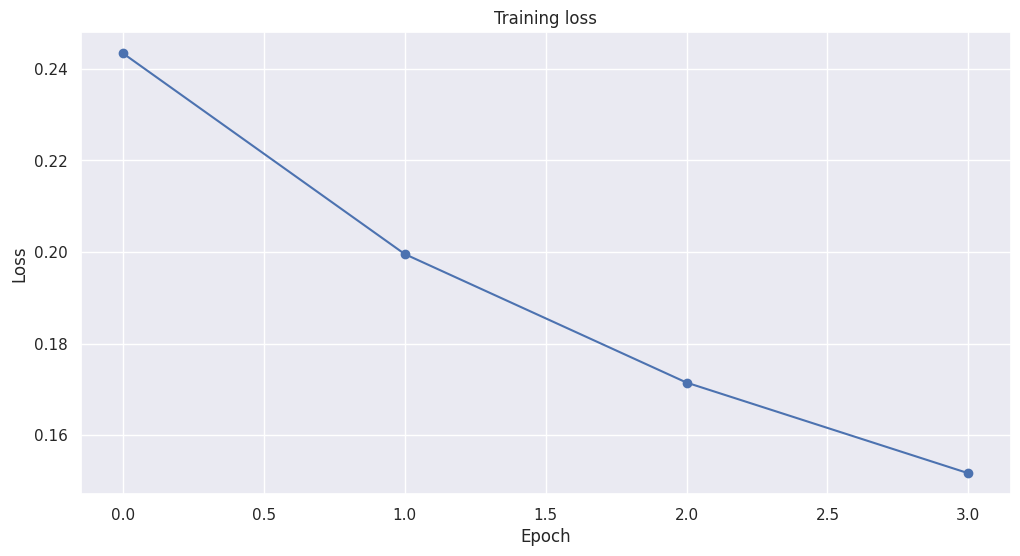

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

---

## **4. Evaluation**

### **4.1 Preparing Test Data**

In [36]:
df = pd.read_csv("en_fce_dev.tsv", delimiter='\t',skip_blank_lines=False ,header=None, names=['token', 'label'])

sentences = []
labels = []
unique_labels = set()

temp_sentences = []
temp_labels = []

for index, row in df.iterrows():
    if pd.notna(row["token"]):
        temp_sentences.append(row['token'])
        temp_labels.append(row['label'])
    else:
        sentences.append(temp_sentences)
        labels.append(temp_labels)
        unique_labels.update(temp_labels)
        temp_sentences = []
        temp_labels = []

if temp_sentences:
    sentences.append(temp_sentences)
    labels.append(temp_labels)
    unique_labels.update(temp_labels)

input_ids = []
attention_masks = []

for sent in sentences:
    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'][0])
    attention_masks.append(encoded_dict['attention_mask'][0])

new_labels = []
null_label_id = -100
for sen, orig_labels in zip(input_ids, labels):
  padded_labels = []
  orig_labels_i = 0
  n = len(orig_labels)
  for token_id in sen:
    token_id = token_id.numpy().item()
    if (token_id == tokenizer.pad_token_id) or (token_id == tokenizer.cls_token_id) or (token_id == tokenizer.sep_token_id):
      padded_labels.append(null_label_id)
    elif tokenizer.ids_to_tokens[token_id][0:2] == "##":
      padded_labels.append(null_label_id)
    else:
      if orig_labels_i < n:
        padded_labels.append(label_map[orig_labels[orig_labels_i]])
        orig_labels_i += 1
  new_labels.append(padded_labels)

from keras.utils import pad_sequences

input_ids = pad_sequences(input_ids, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")
new_labels = pad_sequences(new_labels, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")


input_ids_tensors = [torch.tensor(arr) for arr in input_ids]
attention_masks_tensors = [torch.tensor(arr) for arr in attention_masks]

pt_input_ids = torch.stack(input_ids_tensors, dim=0)
pt_attention_masks = torch.stack(attention_masks_tensors, dim=0)
pt_labels = torch.tensor(new_labels)

batch_size = 32

prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-36-63e5d7f99961>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks_tensors = [torch.tensor(arr) for arr in attention_masks]


### **4.2 Prediction on Test Data**

In [37]:
print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

model.eval()

predictions , true_labels = [], []
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)
  logits = result.logits
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

Predicting labels for 2,191 test sentences...


### **4.3 Performance on Test Data**

In [38]:
from sklearn.metrics import f1_score

all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)
print("After flattening the batches, the predictions have shape: ", all_predictions.shape)
predicted_label_ids = np.argmax(all_predictions, axis=2)
print("After choosing the highest scoring label for each token:", predicted_label_ids.shape)
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)
print("After flattening the sentences, we have predictions:", predicted_label_ids.shape)
print("true labels: ", all_true_labels.shape)

After flattening the batches, the predictions have shape:  (2191, 256, 3)
After choosing the highest scoring label for each token: (2191, 256)
After flattening the sentences, we have predictions: (560896,)
true labels:  (560896,)


In [39]:
real_token_predictions = []
real_token_labels = []

for i in range(len(all_true_labels)):
    if not all_true_labels[i] == -100:
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print("After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))

Before filtering out `null` tokens, length = 560,896
After filtering out `null` tokens, length = 35,709


In [40]:
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

f1 = f1_score(real_token_labels, real_token_predictions)
p = precision_score(real_token_labels, real_token_predictions)
r = recall_score(real_token_labels, real_token_predictions)
f05 = fbeta_score(real_token_labels, real_token_predictions, beta=0.5)

print ("F1 score : {:.4}".format(f1))
print ("Precision: {:.4}".format(p))
print ("Recall   : {:.4}".format(r))
print("F0.5 Score: {:.4}".format(f05))

F1 score : 0.9555
Precision: 0.9318
Recall   : 0.9805
F0.5 Score: 0.9412


---

## **5. Inferencing**

In [45]:
sent = input()
encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        #max_length = 64,
                        #pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

input_id = encoded_dict['input_ids']
attention_mask = encoded_dict['attention_mask']
input_id = torch.Tensor(input_id)
attention_mask = torch.Tensor(attention_mask)

bert_tokens = []
for i in input_id:
  for j in i:
    bert_tokens.append(tokenizer.ids_to_tokens[j.item()])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_id = input_id.to(device)
attention_mask = attention_mask.to(device)

predictions = []
with torch.no_grad():
  outputs = model(input_id, token_type_ids=None, attention_mask=attention_mask)
logits = outputs.logits
logits = logits.detach().cpu().numpy()
predictions.append(logits)

all_predictions = np.concatenate(predictions, axis=0)
predicted_label_ids = np.argmax(all_predictions, axis=2)
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)

print(bert_tokens[1:-1])
print(predicted_label_ids[1:-1])

I am eat apples
['i', 'am', 'eat', 'apples']
[1 1 0 1]


---

## **6. Pushing Fine-Tuned Model to HuggingFace**

In [46]:
!pip install huggingface_hub

In [47]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [49]:
model.push_to_hub("sahilnishad/BERT-GED-FCE-FT")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sahilnishad/BERT-GED-FCE-FT/commit/6808c3339e2598a6a40b4741e126b63d8f338037', commit_message='Upload BertForTokenClassification', commit_description='', oid='6808c3339e2598a6a40b4741e126b63d8f338037', pr_url=None, pr_revision=None, pr_num=None)